In [19]:
import os

# os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
# os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import *
from POSEIDON.utility import read_high_res_data_deprecate
import numpy as np
from scipy import constants
from numba import jit
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import h5py
import matplotlib.pyplot as plt

In [64]:
from POSEIDON.core import define_model, wl_grid_constant_R


R_s = 1.458 * R_Sun  # Stellar radius (m)
T_s = 6776  # Stellar effective temperature (K)
Met_s = 0.13  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24  # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

F_s = star["F_star"]
wl_s = star["wl_star"]

# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

R_p = 0.118 * R_s  # Planetary radius (m)
M_p = 1.157 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.97 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2450  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# %%
from POSEIDON.core import define_model, wl_grid_constant_R
from POSEIDON.utility import read_high_res_data_deprecate

# ***** Define model *****#

model_name = "Fe Cr Mg Madhu injection"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["Fe", "Cr"]

high_res = "sysrem"
high_res_params = ["K_p", "V_sys", "W_conv", "log_alpha"]

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="gradient",
    high_res_params=high_res_params,
    cloud_model="MacMad17",
    cloud_type="deck",
    # reference_parameter="None",
)

model["method"] = "sysrem"
model["spectrum_type"] = "transmission"
# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

# ***** Wavelength grid *****#

wl_min = 0.37  # Minimum wavelength (um)
wl_max = 0.51  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid

# wl = wl_grid_line_by_line(wl_min, wl_max)
wl = wl_grid_constant_R(wl_min, wl_max, R)

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2500  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 3500  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 50  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -12.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Free parameters: ['R_p_ref' 'T_high' 'T_deep' 'log_Fe' 'log_Cr' 'log_P_cloud' 'K_p' 'V_sys'
 'W_conv' 'log_alpha']


In [65]:
P_min = 1.0e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

log_species = [-6, -6]

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([2500, 3500])
log_X_params = np.array([log_species])
cloud_params = np.array([0])

atmosphere = make_atmosphere(
    planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="transmission",
)

param_species = []
log_X_params = np.array([])

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="gradient",
    high_res_params=high_res_params,
    cloud_model="MacMad17",
    cloud_type="deck",
    # reference_parameter="None",
)

atmosphere = make_atmosphere(
    planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params
)

# Generate planet surface flux
continuum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="transmission",
)

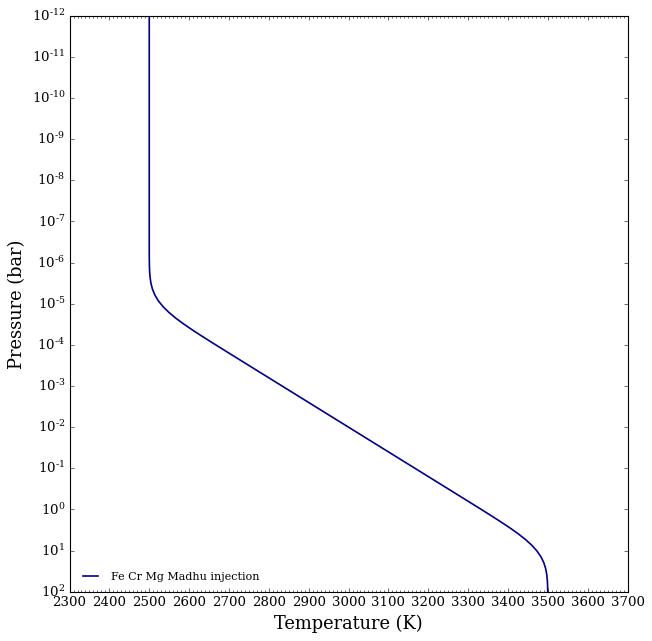

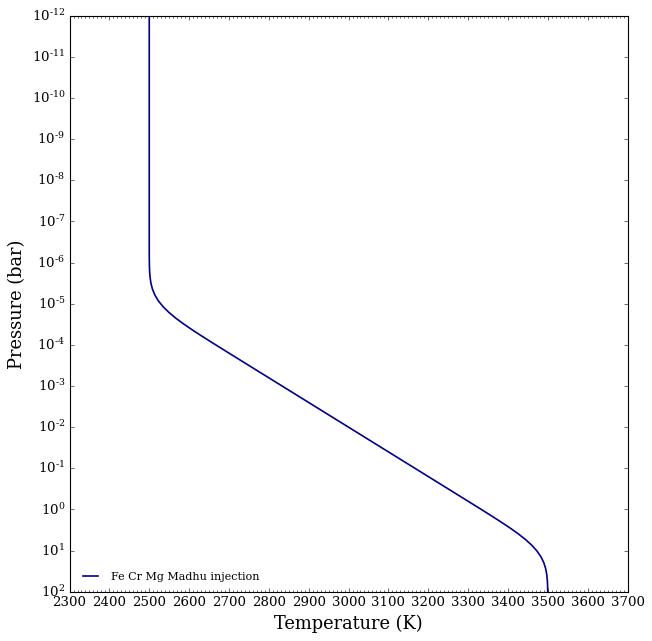

In [66]:
from POSEIDON.visuals import plot_PT

plot_PT(planet, model, atmosphere)

In [67]:
def make_injection_data(
    data,
    data_dir,
    name,
    wl,
    planet_spectrum,
    K_p,
    V_sys,
    method,
    a=1,
    W_conv=None,
    star_spectrum=None,
):
    flux = data["data_raw"]
    wl_grid = data["wl_grid"]
    phi = data["phi"]
    if "V_bary" in data.keys():
        V_bary = data["V_bary"]
    else:
        V_bary = np.zeros_like(phi)

    nord, nphi, npix = flux.shape
    planet_spectrum = gaussian_filter1d(planet_spectrum, W_conv)
    emission = star_spectrum is not None

    if emission:
        spectrum_type = "emission"
        star_spectrum = gaussian_filter1d(star_spectrum, W_conv)
        transit_weight = None
    else:
        spectrum_type = "transmission"
        transit_weight = data["transit_weight"]
        max_transit_depth = np.max(1 - transit_weight)
    # Time-resolved total radial velocity
    radial_velocity = V_sys + V_bary + K_p * np.sin(2 * np.pi * phi)
    # V_sys is an additive term around zero
    delta_lambda = radial_velocity * 1e3 / constants.c  # delta lambda, for shifting

    F_p_F_s = np.zeros((nord, nphi, npix))
    F_p = np.zeros((nord, nphi, npix))

    for i in range(nord):  # Nord = 44 This takes 2.2 seconds to complete
        wl_slice = wl_grid[i].copy()  # Cropped wavelengths
        for j in range(nphi):  # This for loop takes 0.025 seconds Nphi = 79
            wl_shifted_p = wl_slice * (1.0 - delta_lambda[j])
            if emission:
                F_p_F_s[i, j, :] = np.interp(
                    wl_shifted_p, wl, planet_spectrum
                ) / np.interp(wl_slice, wl, star_spectrum)
            else:
                F_p[i, j, :] = (
                    -np.interp(wl_shifted_p, wl, planet_spectrum)
                    * (1 - transit_weight[j])
                    / max_transit_depth
                    + 1
                )

    flux[flux < 5] = 5
    data_injected = F_p * flux
    add_high_res_data(
        data_dir,
        name,
        data_injected,
        wl_grid,
        phi,
        transit_weight=transit_weight,
        overwrite=True,
    )

    prepare_high_res_data(data_dir, name, spectrum_type, method, overwrite=True)

    return

In [68]:
import h5py

with h5py.File("./data/WASP-121b/blue/data_raw.hdf5", "r") as f:
    data = {}
    data["data_raw"] = f["flux"][:]
    data["wl_grid"] = f["wl_grid"][:]
    data["phi"] = f["phi"][:]
    data["transit_weight"] = f["transit_weight"][:]

In [69]:
names = ["Fe_Cr_cloud=0_isotherm"]
inject_dir = "./data/WASP-121b-gradient-injection/"

for name in names:
    make_injection_data(
        data,
        inject_dir,
        name,
        wl,
        (spectrum - continuum) * 3 + continuum,
        -200,
        -20,
        "sysrem_2022",
        W_conv=1,
    )

Overwriting data at ./data/WASP-121b-gradient-injection/Fe_Cr_cloud=0_isotherm/data_raw.hdf5
Overwriting data at ./data/WASP-121b-gradient-injection/Fe_Cr_cloud=0_isotherm/data_processed.hdf5
Fitting Poisson uncertainties with 5 components
Blaze correcting data with median filter size 15 and gaussian filter size 50
Filtering out systematics using SYSREM with 15 iterations


In [56]:
from PyAstronomy import pyasl
import POSEIDON

names = ["Fe_Cr_cloud=-2_isotherm"]
data = read_high_res_data(inject_dir, names=names)

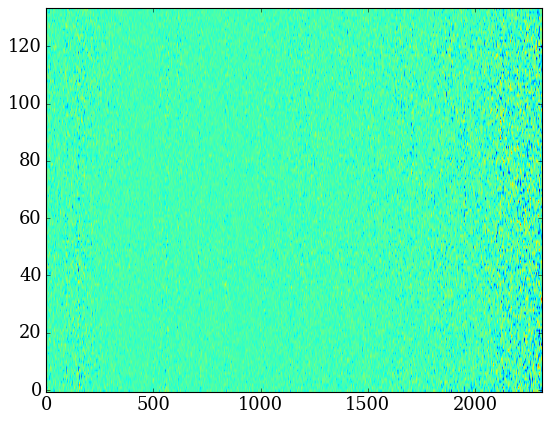

In [57]:
plt.imshow(
    data["Fe_Cr_cloud=-2_isotherm"]["residuals"][0], aspect="auto", origin="lower"
)

In [58]:
def cross_correlate(
    Kp_range, Vsys_range, RV_range, wl, planet_spectrum, data, Print=True
):
    if Print:
        time0 = time.time()

    residuals = data["residuals"]
    # uncertainties = np.ones_like(residuals)
    uncertainties = data["uncertainties_processed"]
    phi = data["phi"]
    wl_grid = data["wl_grid"]
    if "transit_weight" in data.keys():
        spectrum_type = "transmission"
        transit_weight = data["transit_weight"]
        max_transit_depth = np.max(1 - transit_weight)
    else:
        spectrum_type = "emission"

    nord, nphi, npix = residuals.shape
    CCF_Kp_Vsys = np.zeros((len(Kp_range), len(Vsys_range)))

    nRV = len(RV_range)
    CCF_phase_RV = np.zeros((nphi, nRV))
    models_shifted = np.zeros((nRV, nord, npix))
    for RV_i, RV in enumerate(RV_range):
        # Looping through each order and computing total log-L by summing logLs for each obvservation/order
        for ord_i in range(nord):
            wl_slice = wl_grid[ord_i]  # Cropped wavelengths
            delta_lambda = RV * 1e3 / constants.c
            wl_shifted = wl * (1.0 + delta_lambda)
            F_p = np.interp(wl_slice, wl_shifted, planet_spectrum)
            models_shifted[RV_i, ord_i] = F_p  # choose not to filter

    # negative of transmission spectrum gives absorption. Adding or multiplying constant does not change the CCF
    if spectrum_type == "emission":
        m = models_shifted
    elif spectrum_type == "transmission":
        m = -models_shifted

    for phi_i in range(nphi):
        for RV_i in range(nRV):
            f = residuals[:, phi_i, :]
            CCF = np.sum(f[:, :] * m[RV_i, :, :] / uncertainties[:, phi_i, :] ** 2)
            CCF_phase_RV[phi_i, RV_i] += CCF

    if spectrum_type == "transmission":
        CCF_phase_RV = (1 - transit_weight[:, None]) * CCF_phase_RV

    for Kp_i, Kp in enumerate(Kp_range):
        for phi_i in range(nphi):
            RV = Kp * np.sin(2 * np.pi * phi[phi_i]) + Vsys_range  # + V_bary[phi_i]
            CCF_Kp_Vsys[Kp_i] += np.interp(RV, RV_range, CCF_phase_RV[phi_i])
    if Print:
        time1 = time.time()
        print("Cross correlation took {} seconds".format(time1 - time0))
    return CCF_Kp_Vsys, CCF_phase_RV

In [59]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d

Kp_range = np.arange(-300, 301, 1)
Vsys_range = np.arange(-200, 201, 1)
RV_range = np.arange(-500, 501, 1)

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        wl,
        # gaussian_filter1d(
        #     spectrum - gaussian_filter1d(minimum_filter1d(spectrum, 400), 100), 3
        # ),
        gaussian_filter1d(spectrum, 1),
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlation took 61.221699476242065 seconds


In [60]:
def plot_CCF_phase_RV(
    phi,
    RV_range,
    CCF_phase_RV,
    species,
    plot_label=False,
    save_path=None,
    cmap=cmr.ember,
):
    for i in range(len(CCF_phase_RV)):
        CCF_phase_RV[i] = CCF_phase_RV[i] - np.mean(CCF_phase_RV[i])
        # CCF_per_phase[i] = CCF_per_phase[i] / stdev
        CCF_phase_RV[i] /= np.std(CCF_phase_RV[i])
    # stdev = np.std(CCF_phase_RV)
    # maxx = (CCF_phase_RV).max()
    fig, ax = plt.subplots(figsize=(10.667, 3), constrained_layout=False)
    im = ax.imshow(
        CCF_phase_RV,
        extent=[RV_range.min(), RV_range.max(), phi.min(), phi.max()],
        aspect="auto",
        interpolation="bilinear",
        cmap=cmap,
        origin="lower",
    )
    if plot_label:
        ax.text(
            0.05,
            0.3,
            species,
            ha="left",
            va="top",
            transform=ax.transAxes,
            color="white",
            fontsize=32,
        )

    cbar = plt.colorbar(im)
    # ax.plot(
    #     np.arange(-180, -50),
    #     (np.arange(-180, -50) + 100) / (200) / (2 * np.pi)
    #     + 0.4,  # phi start from 90 degrees. sin(phi-90) -90 = -phi
    #     "--",
    #     color="red",
    #     alpha=0.5,
    # )
    # plot(V_sys_arr[loc[1]], phi[loc[0]], "xk", ms=7)
    # axis([V_sys_arr.min(), V_sys_arr.max(), phi.min(), phi.max()])
    ax.set_xlabel(r"$\rm{V_p}$ (km/s)")
    ax.set_ylabel(r"$\phi$", rotation=0, labelpad=20)
    ax.set_title(r"$\Delta$ CCF ($\sigma$)")
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0.1)
    return

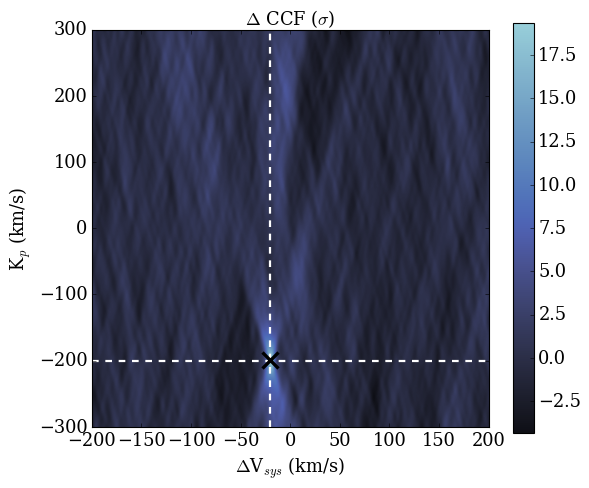

In [61]:
def plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    CCF_Kp_Vsys,
    species,
    Kp,
    Vsys=0,
    RM_mask_size=10,
    plot_slice=False,
    plot_label=False,
    savefig=False,
    file_path=None,
    cmap=cmr.ember,
):
    # Expected value
    CCF_Kp_Vsys = CCF_Kp_Vsys - np.mean(CCF_Kp_Vsys)
    idx = find_nearest_idx(Vsys_range, Vsys)
    mask = np.ones(len(Vsys_range), dtype=bool)
    mask[idx - RM_mask_size : idx + RM_mask_size] = False
    stdev = np.std(CCF_Kp_Vsys[:, mask])
    maxx = (CCF_Kp_Vsys / stdev).max()

    loc = np.where(CCF_Kp_Vsys / stdev == maxx)

    colors = cmr.take_cmap_colors(cmap, 10, cmap_range=(0.1, 0.9), return_fmt="hex")
    if plot_slice:
        fig, axes = plt.subplots(
            2,
            1,
            figsize=(8, 10),
            constrained_layout=True,
            gridspec_kw={"height_ratios": [8, 2]},
        )
        ax1 = axes[0]
        ax2 = axes[1]
        idx = find_nearest_idx(Kp_range, Kp)
        slicee = CCF_Kp_Vsys[idx] / stdev
        ax2.plot(Vsys_range, slicee, c=colors[5])
        ax2.axis(
            [
                np.min(Vsys_range),
                np.max(Vsys_range),
                1.1 * slicee.min(),
                1.1 * slicee.max(),
            ]
        )
        ax2.set_xlabel(r"$\Delta$V$_{sys}$(km/s)")
        ax2.set_ylabel(r"$\Delta$ CCF ($\sigma$)")
        ax2.set_title("Slice at K$_{p}$ = " + str(Kp) + " km/s")
        ax2.axvline(x=Vsys, ls="--", color="black")
    else:
        fig, ax1 = plt.subplots(figsize=(8, 8), constrained_layout=False)
    im = ax1.imshow(
        CCF_Kp_Vsys / stdev,
        extent=[Vsys_range.min(), Vsys_range.max(), Kp_range.min(), Kp_range.max()],
        aspect=len(Vsys_range) / len(Kp_range),
        interpolation="bilinear",
        cmap=cmap,
        origin="lower",
    )
    if plot_label:
        ax1.text(
            0.05,
            0.15,
            species,
            ha="left",
            va="top",
            transform=ax1.transAxes,
            color="white",
            fontsize=32,
        )
    cbar = plt.colorbar(im, ax=ax1, shrink=0.8)
    ax1.axvline(x=Vsys, color="white", ls="--", lw=2)
    ax1.axhline(y=Kp, color="white", ls="--", lw=2)
    ax1.plot(Vsys_range[loc[1]], Kp_range[loc[0]], "xk", ms=15, mew=3)
    ax1.set_xlabel("$\Delta$V$_{sys}$ (km/s)")
    ax1.set_ylabel(r"K$_{p}$ (km/s)")
    ax1.set_title(r"$\Delta$ CCF ($\sigma$)")

    if savefig:
        plt.savefig(file_path, bbox_inches="tight", pad_inches=0.1)

    return


plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    np.sum(CCF_Kp_Vsys_all[:], axis=0),
    "All",
    -200,
    Vsys=-20,
    RM_mask_size=100,
    plot_label=False,
    cmap=cmr.get_sub_cmap("cmr.sapphire", 0.1, 0.9),
    file_path="./CC_output/WASP121_injection_CCF.pdf",
    savefig=True,
)

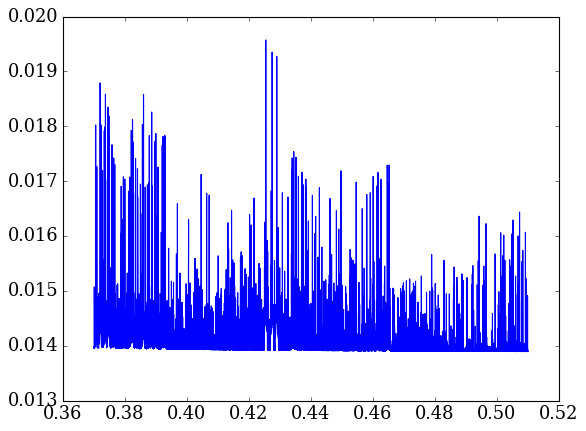

In [62]:
plt.plot(wl, spectrum)

In [ ]:
phi = data["blue"]["phi"]
transit_weight = data["blue"]["transit_weight"]
in_transit = transit_weight != 1
plot_CCF_phase_RV(
    phi[in_transit],
    RV_range,
    np.mean(CCF_phase_RV_all, axis=0)[in_transit],
    "Fe",
    plot_label=False,
    save_path="./CC_output/WASP121_injection_CCF_phase.pdf",
    cmap=cmr.get_sub_cmap("cmr.sapphire", 0.1, 0.9),
)